In [66]:
import spectral as spy
import matplotlib.pyplot as plt
import pandas as pd
from Code.find_path_nextcloud import find_path_nextcloud
import os
import numpy as np

In [50]:
path_nextcloud = find_path_nextcloud()

# Festlegung, welches Grid zusammengelegt werden soll
windowsize_r = 200
windowsize_c = 200

# Bestimmung annotation_folder
grid_folder = path_nextcloud + "Daten_Gyrocopter/Oldenburg/Teilbilder/grid_" + str(windowsize_r) + "_" + str(
    windowsize_c)
labeled_folder = grid_folder + '/labeled/'

# Liste aller Dateien in annotation_folder erstellen
files = os.listdir(labeled_folder)

# Aus Liste files .hdr Dateien löschen
for file in files:
    if not file.endswith('.dat'):
        files.remove(file)

In [51]:
files

['Teilbild_Oldenburg_00000000_00000000_0_0_.dat',
 'Teilbild_Oldenburg_00000000_00000002_0_400_.dat',
 'Teilbild_Oldenburg_00000000_00000008_0_1600_.dat',
 'Teilbild_Oldenburg_00000000_00000009_0_1800_.dat',
 'Teilbild_Oldenburg_00000000_00000014_0_2800_.dat',
 'Teilbild_Oldenburg_00000000_00000015_0_3000_.dat',
 'Teilbild_Oldenburg_00000002_00000008_400_1600_.dat',
 'Teilbild_Oldenburg_00000009_00000011_1800_2200_.dat']

In [55]:
def isfloat(num):
    try:
        float(num)
        return True
    except ValueError:
        return False
    
path_dat = labeled_folder + os.path.splitext(files[0])[0] + '.dat'
path_hdr = labeled_folder + os.path.splitext(files[0])[0] + '.hdr'
# load image
img = spy.envi.open(file=path_hdr, image=path_dat)

# load image array
arr = img.load()

# convert only wavelength into dataframe and round numbers
value_bands = ['hsi_band_' + str(int(float(x))) + '_nm' for x in img.metadata['wavelength'] if isfloat(x)]
value_bands.extend(['thermal', 'dom'])

label_bands = ['None', 'Wiese', 'Straße', 'Auto', 'See', 'Schienen', 'Haus', 'Wald', 'label']

bands = []
bands.extend(value_bands)
bands.extend(label_bands)


# convert array in dataframe
# every line represent one pixel
# every column represent one band
df_bands = pd.DataFrame(arr.reshape((40000, arr.shape[2])), columns=bands)

In [56]:
df_bands.drop(columns=['dom','None', 'Wiese', 'Straße', 'Auto', 'See', 'Schienen', 'Haus', 'Wald'], inplace=True)

In [57]:
X = df_bands.drop(columns=['label'])
y = df_bands['label']

In [58]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [59]:
from sklearn.naive_bayes import MultinomialNB, GaussianNB

classifier = MultinomialNB()
classifier.fit(X_train,y_train)

MultinomialNB()

In [63]:
from sklearn.metrics import confusion_matrix,accuracy_score, precision_recall_fscore_support

def print_score(classifier,X_train,y_train,X_test,y_test,labels,train=True):
    if train == True:
        print("Trainingsergebnisse:\n")
        y_train_predict = classifier.predict(X_train)
        print('Genauigkeit: {0:.4f}\n'.format(accuracy_score(y_train,y_train_predict)))
        print('Vertauschungsmatrix:\n{}\n'.format(confusion_matrix(y_train,y_train_predict)))
        prec,rec,fsc,sup = precision_recall_fscore_support(y_train,y_train_predict, average=None,labels=labels)
        precA,recA,fscA,supA = precision_recall_fscore_support(y_train,y_train_predict, average='macro',labels=labels)
        print('Precision: {} '.format(prec))
        print('Av.: {0:.4f}\n'.format(precA))
        print('Recall: {}'.format(rec))
        print('Av.: {0:.4f}\n'.format(recA))
        print('F-Measure: {}'.format(fsc))
        print('Av.: {0:.4f}\n'.format(fscA))
        print('Support: {}\n'.format(sup))
    elif train == False:
        print("Testergebnisse:\n")
        y_test_predict = classifier.predict(X_test)
        print('Genauigkeit: {0:.4f}\n'.format(accuracy_score(y_test,y_test_predict)))
        print('Vertauschungsmatrix:\n{}\n'.format(confusion_matrix(y_test,y_test_predict)))
        prec,rec,fsc,sup = precision_recall_fscore_support(y_test, y_test_predict, average=None,labels=labels)
        precA,recA,fscA,supA = precision_recall_fscore_support(y_test, y_test_predict, average='macro',labels=labels)
        print('Precision: {} '.format(prec))
        print('Av.: {0:.4f}\n'.format(precA))
        print('Recall: {}'.format(rec))
        print('Av.: {0:.4f}\n'.format(recA))
        print('F-Measure: {}'.format(fsc))
        print('Av.: {0:.4f}\n'.format(fscA))
        print('Support: {}\n'.format(sup))


In [64]:
print_score(classifier,X_train,y_train,X_test,y_test,np.unique(y),train=True) #auf Trainingsdaten

Trainingsergebnisse:

Genauigkeit: 0.4849

Vertauschungsmatrix:
[[ 695  980  619 3419  747]
 [ 404 3807  809  541 4087]
 [  40   34    8  397  299]
 [ 590  175  249 5534   57]
 [  83  732  124   38 3532]]

Precision: [0.38355408 0.66462989 0.00442233 0.55735724 0.40495299] 
Av.: 0.4030

Recall: [0.10758514 0.39458955 0.01028278 0.83785011 0.78332224]
Av.: 0.4267

F-Measure: [0.16803675 0.4951873  0.00618477 0.66940849 0.53389766]
Av.: 0.3745

Support: [6460 9648  778 6605 4509]



In [78]:
spy.get_rgb(arr, bands=(59, 29, 1), stretch=(0.01, 0.98), stretch_all=True)

array([[[0.55575015, 0.68027457, 0.58687259],
        [0.53093987, 0.68171965, 0.59790403],
        [0.55604203, 0.70953757, 0.65581908],
        ...,
        [0.43666083, 0.62789017, 0.58687259],
        [0.47343841, 0.61488439, 0.37065637],
        [0.49649737, 0.58887283, 0.14782129]],

       [[0.53940455, 0.67268786, 0.57970215],
        [0.55283129, 0.69725434, 0.60948704],
        [0.55837712, 0.71387283, 0.62824049],
        ...,
        [0.41798015, 0.63041908, 0.61059018],
        [0.41798015, 0.63041908, 0.61059018],
        [0.45213076, 0.63800578, 0.58576944]],

       [[0.54232341, 0.68894509, 0.567016  ],
        [0.5545826 , 0.70556358, 0.58356315],
        [0.5545826 , 0.70556358, 0.58356315],
        ...,
        [0.41214244, 0.61885838, 0.64644236],
        [0.40659661, 0.62102601, 0.64147821],
        [0.40134267, 0.5982659 , 0.58521787]],

       ...,

       [[0.35580852, 0.39595376, 0.13734142],
        [0.35580852, 0.39595376, 0.13734142],
        [0.27583187, 0

C:\Users\fgrassxx\AppData\Local\Temp\ipykernel_26692\1120446936.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


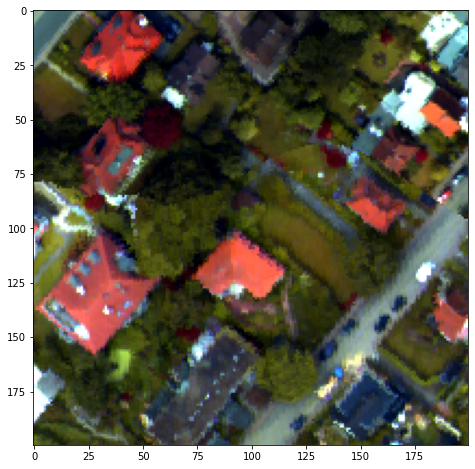

In [79]:
# Plot Subimage
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(spy.get_rgb(arr, bands=(59, 26, 1), stretch=(0.02, 0.98), stretch_all=True))
fig.show()


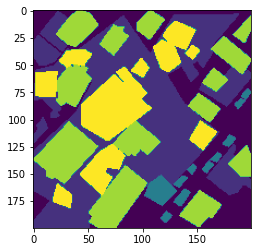

In [80]:
plt.imshow(arr[:,:,-1])

In [81]:
arr2 = np.array(df_bands)

In [82]:
arr2.shape

(40000, 109)

In [83]:
t = np.reshape(arr2, (200,200,109))

In [84]:
t.shape

(200, 200, 109)

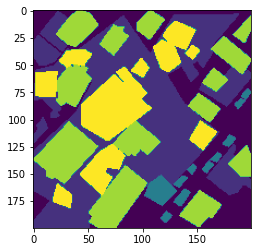

In [85]:
plt.imshow(t[:,:,-1])

In [86]:
pd.DataFrame(columns=bands)

,hsi_band_430_nm,hsi_band_434_nm,hsi_band_439_nm,hsi_band_443_nm,hsi_band_448_nm,hsi_band_452_nm,hsi_band_457_nm,hsi_band_461_nm,hsi_band_466_nm,hsi_band_470_nm,...,dom,None,Wiese,Straße,Auto,See,Schienen,Haus,Wald,label
